In [1]:
from data.loader import fetch_spot_history, fetch_option_quotes, clean_option_quotes

# 1. Spot history
df_spot = fetch_spot_history("SPY", start="2021-01-01", end="2021-01-10")
display(df_spot.head(), df_spot.shape)

# 2. Option quotes
df_opts = fetch_option_quotes("SPY")
display(df_opts.head(), df_opts.shape)

# 3. Cleaned quotes
df_clean = clean_option_quotes(df_opts)
display(df_clean.head(), df_clean.shape)


YF.download() has changed argument auto_adjust default to True


Price,date,Open,High,Low,Close,Volume
0,2021-01-04,353.394019,353.525858,343.516585,347.254761,110210800
1,2021-01-05,346.605116,350.748176,346.558018,349.646484,66426200
2,2021-01-06,348.121144,354.966638,347.565600,351.736908,107997700
3,2021-01-07,354.137981,357.716072,353.959074,356.962799,68766800
4,2021-01-08,358.365694,359.213133,355.079499,358.996582,71677200


(5, 6)

,strike,bid,ask,mid_price,mid_iv,expiry,type
0,473.0,90.34,92.47,91.405,0.941407,2025-05-12,call
1,474.0,89.34,91.47,90.405,0.929688,2025-05-12,call
2,481.0,82.34,84.47,83.405,0.859376,2025-05-12,call
3,492.0,71.34,73.47,72.405,0.750003,2025-05-12,call
4,500.0,63.35,65.47,64.410,0.677738,2025-05-12,call


(7213, 7)

,strike,bid,ask,mid_price,mid_iv,expiry,type
0,473.0,90.34,92.47,91.405,0.941407,2025-05-12,call
1,474.0,89.34,91.47,90.405,0.929688,2025-05-12,call
2,481.0,82.34,84.47,83.405,0.859376,2025-05-12,call
3,492.0,71.34,73.47,72.405,0.750003,2025-05-12,call
4,500.0,63.35,65.47,64.410,0.677738,2025-05-12,call


(7099, 7)

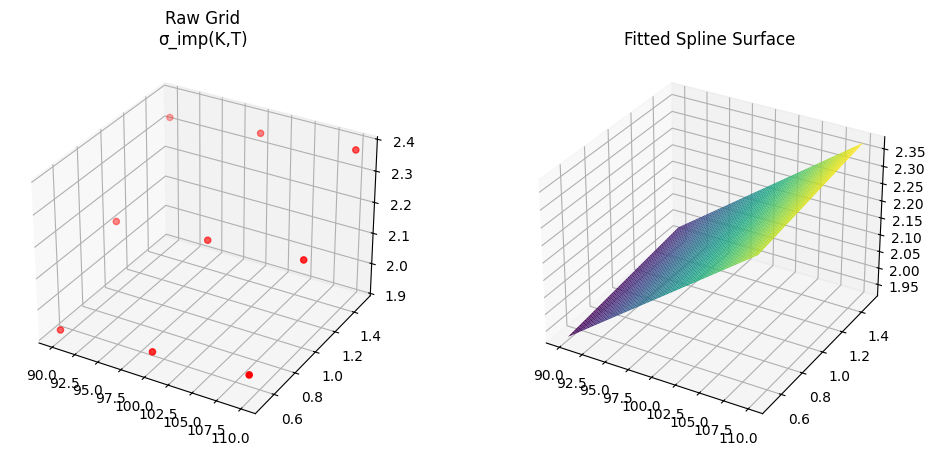

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model.surface import fit_iv_surface

# 1. Construct a toy surface
Ks = np.array([90, 100, 110])
Ts = np.array([0.5, 1.0, 1.5])
IV = np.empty((len(Ts), len(Ks)))
for i, T in enumerate(Ts):
    for j, K in enumerate(Ks):
        IV[i, j] = 0.1 + 0.02*K + 0.05*T

# 2. Fit the spline
iv_func = fit_iv_surface(Ks, Ts, IV, kx=1, ky=1)

# 3. Build a dense evaluation grid
Kg = np.linspace(90, 110, 50)
Tg = np.linspace(0.5, 1.5, 50)
KK, TT = np.meshgrid(Kg, Tg)
ZZ = np.vectorize(iv_func)(KK, TT)

# 4. Plot
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.scatter(np.repeat(Ks, len(Ts)), np.tile(Ts, len(Ks)), IV.ravel(), color='r')
ax1.set_title("Raw Grid\nσ_imp(K,T)")

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(KK, TT, ZZ, cmap='viridis', edgecolor='none')
ax2.set_title("Fitted Spline Surface")

plt.show()


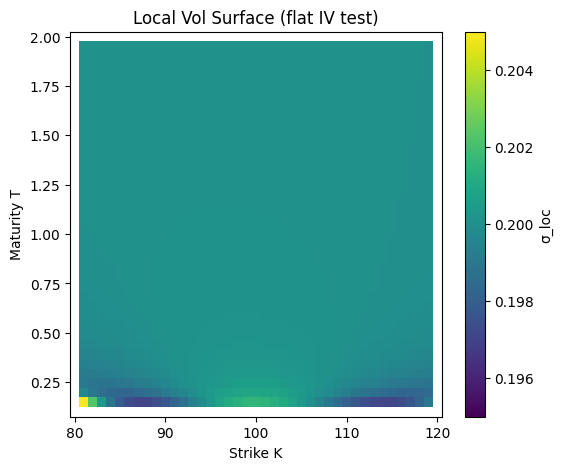

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from model.local_vol import dupire_local_vol

# 1. Define a test implied-vol surface and grid
sigma0 = 0.2
iv_func = lambda K, T: sigma0

Ks = np.linspace(80, 120, 41)
Ts = np.linspace(0.1, 2.0, 40)

# 2. Compute local-vol
S0, r, q = 100.0, 0.0, 0.0
sigma_loc = dupire_local_vol(S0, Ks, Ts, iv_func, r, q)

# 3. Plot as heatmap
fig, ax = plt.subplots(figsize=(6,5))
pcm = ax.pcolormesh(Ks, Ts, sigma_loc, shading='auto', vmin=0.195, vmax=0.205)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T")
ax.set_title("Local Vol Surface (flat IV test)")
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("σ_loc")
plt.show()


In [1]:
# Cell 1: Heston calibration on a toy market‐IV surface
import numpy as np
from model.heston_calib import calibrate_heston

# toy market: flat 20% IV on strikes × maturities grid
strikes    = np.array([90, 100, 110])
maturities = np.array([0.5, 1.0, 1.5])
market_iv  = np.full((len(maturities), len(strikes)), 0.20)

S0, r, q = 100.0, 0.01, 0.0
calib = calibrate_heston(strikes, maturities, market_iv, S0, r, q)
print("Calibrated Heston parameters:")
for k,v in calib.items():
    print(f"  {k:<6} = {v:.4f}")


c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:59: RuntimeWarning: invalid value encountered in scalar divide
  g = (kappa - rho*xi*iu - d) / (kappa - rho*xi*iu + d)
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:66: RuntimeWarning: invalid value encountered in scalar divide
  - 2.0 * np.log((1 - g * exp_dT) / (1 - g))))
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:66: RuntimeWarning: invalid value encountered in log
  - 2.0 * np.log((1 - g * exp_dT) / (1 - g))))
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:68: RuntimeWarning: invalid value encountered in scalar divide
  D = ((kappa - rho*xi*iu - d) / xi**2) * ((1 - exp_dT) / (1 - g * exp_dT))
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:130: IntegrationWarning: The occurrence of roundoff error is detected, w

Calibrated Heston parameters:
  kappa  = 1.0000
  theta  = 0.0400
  xi     = 0.5000
  rho    = -0.5000
  v0     = 0.0400


In [ ]:
import time
import numpy as np
from model.heston_calib import calibrate_heston

# tiny grid for test
strikes    = np.array([90.0, 100.0, 110.0])
maturities = np.array([0.5, 1.0, 1.5])
market_iv  = np.full((3,3), 0.20)
S0, r, q   = 100.0, 0.01, 0.0

t0 = time.perf_counter()
calib = calibrate_heston(strikes, maturities, market_iv, S0, r, q)
t1 = time.perf_counter()
print(f"3×3 calibration took {t1-t0:.2f} s")


c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:59: RuntimeWarning: invalid value encountered in scalar divide
  g = (kappa - rho*xi*iu - d) / (kappa - rho*xi*iu + d)
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:66: RuntimeWarning: invalid value encountered in scalar divide
  - 2.0 * np.log((1 - g * exp_dT) / (1 - g))))
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:66: RuntimeWarning: invalid value encountered in log
  - 2.0 * np.log((1 - g * exp_dT) / (1 - g))))
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:68: RuntimeWarning: invalid value encountered in scalar divide
  D = ((kappa - rho*xi*iu - d) / xi**2) * ((1 - exp_dT) / (1 - g * exp_dT))
c:\Users\elias\OneDrive\Documents\ESSEC\Option Application\LSV pricer\model\heston_calib.py:130: IntegrationWarning: The occurrence of roundoff error is detected, w

3×3 calibration took 19.31 s


In [8]:
t0 = time.perf_counter()
calib = calibrate_heston(strikes_full, times_full, iv_mat_full, S0, r, q)
t1 = time.perf_counter()
print(f"11×11 calibration took {t1-t0:.2f} s")


NameError: name 'strikes_full' is not defined